In [59]:
import random
import sys
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [60]:
from src.modules import conf, fit, df_columns, evl, preprocess
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import haversine as hs
from gpx_converter import Converter
from datetime import datetime
from xgboost import XGBRFRegressor, XGBRegressor
import statsmodels.api as sm
warnings.simplefilter("ignore")

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [63]:
# race_day = datetime.strptime('2022-10-08-10-30', '%Y-%m-%d-%H-%M') # Hradec
race_day = datetime.strptime('2023-03-11-10-00', '%Y-%m-%d-%H-%M') # PALESTRA

In [64]:
data = fit.load_pcls(
        athlete_name='zahradnik',
        activity_type='running',
        path_to_load=conf["Paths"]["pcl"],
    )

100%|██████████| 386/386 [00:00<00:00, 1672.76it/s]


In [65]:
# ZONES ADD
for x in range(len(data)):
    data[x] = data[x][df_columns]
    mean_hr = np.mean(data[x].heart_rate)
    if mean_hr < 140:
        zone = 1
    elif mean_hr > 140 and mean_hr < 156:
        zone = 2
    elif mean_hr > 156 and mean_hr < 166:
        zone = 3
    elif mean_hr > 166 and mean_hr < 175:
        zone = 4
    elif mean_hr > 175:
        zone = 5
    data[x]['hr_zone'] = zone

In [66]:
low_dist = []
high_dist = []
for act in data:
    if np.max(act.distance) > 10000:
        high_dist.append(act)
    else:
        low_dist.append(act)
len(low_dist),len(high_dist)

(149, 237)

In [67]:
train_df = fit.clean_data(pd.concat(data))
len(train_df)

922730

In [68]:
speed_train = train_df.enhanced_speed
heart_train = train_df.heart_rate
cad_train = train_df.cadence

train_df.drop("enhanced_speed",axis=1,inplace=True)
train_df.drop("heart_rate",axis=1,inplace=True)
train_df.drop("cadence",axis=1,inplace=True)

In [69]:
df = Converter(input_file='silvestrak_mapy.gpx').gpx_to_dataframe()
df['enhanced_altitude'] = df.altitude
df.drop("altitude",axis=1,inplace=True)

In [70]:
def calc_dist(pos1: tuple,pos2: tuple) -> int:
    return hs.haversine(pos1, pos2, unit=hs.Unit.METERS)

In [71]:
## DISTANCE
df['dist_diff'] = [0] + [calc_dist(
    (df['latitude'].iloc[x], df['longitude'].iloc[x]),
    (df['latitude'].iloc[x+1], df['longitude'].iloc[x+1])) for x in range(len(df)-1)]

df['distance'] = df['dist_diff'].cumsum()

In [72]:
np.max(df.distance)

5201.737224898904

In [73]:
df["temp"], df["wind_speed"], df["wind_direct"], df["rain"] = preprocess.get_meteo(
    df.latitude.iloc[0],
    df.longitude.iloc[0],
    df.enhanced_altitude.iloc[0],
    race_day
)
df.drop(['latitude','longitude'],axis=1,inplace=True)

In [74]:
df["slope_ascent"], df["slope_descent"] = preprocess.calc_ascent_descent(df)

df["slope_steep"] = preprocess.calc_slope_steep(df)

In [75]:
df['hr_zone'] = 5
# df.set_index(["time"], inplace=True)

In [76]:
test_df= df

In [77]:
# from feature_engine.datetime import DatetimeFeatures
# train_df['date'] = train_df.index
# test_df['date'] = test_df.index
# dtf = DatetimeFeatures(features_to_extract=['month','week','hour','minute','second'])
# train_df= dtf.fit_transform(train_df)
# test_df= dtf.fit_transform(test_df)

In [78]:
len(train_df.columns),len(test_df.columns)

(11, 11)

In [79]:
from feature_engine.timeseries.forecasting import WindowFeatures

lagged_cols = ['slope_steep', 'slope_ascent', 'slope_descent']
lagged = 18
for lag in range(1, lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)

In [80]:
for colname in train_df.columns:
    if 'mean' in colname:
        train_df[colname].fillna(0, inplace=True)
        test_df[colname].fillna(0, inplace=True)

In [81]:
len(train_df.columns),len(test_df.columns)

(62, 62)

In [82]:
test_df = test_df[train_df.columns]

In [83]:
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV, ElasticNetCV, LassoCV
clf = XGBRFRegressor()
percent_delay = int(len(test_df) * 0.02)  ## 2% delay
clf.fit(train_df, cad_train)
y_pred_cad = clf.predict(test_df)

In [84]:
train_df['cadence'] = cad_train
test_df['cadence'] = y_pred_cad
len(train_df.columns),len(test_df.columns)

(63, 63)

In [85]:
lagged_cols = ['cadence']
lagged = 18
for lag in range(1, lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)
train_df = fit.clean_data(train_df)
test_df = fit.clean_data(test_df)

In [86]:
clf = XGBRFRegressor()
percent_delay = int(len(test_df) * 0.02)  ## 2% delay
clf.fit(train_df, heart_train)
y_pred_hr = clf.predict(test_df)

In [87]:
train_df['heart_rate'] = heart_train
test_df['heart_rate'] = y_pred_hr
len(train_df.columns),len(test_df.columns)

(64, 64)

In [88]:
lagged_cols = ['heart_rate']
lagged = 18
for lag in range(1, lagged):
    wft = WindowFeatures(variables=lagged_cols,
                         window=lag)
    train_df = wft.fit_transform(train_df)
    test_df = wft.fit_transform(test_df)
len(train_df.columns),len(test_df.columns)

(81, 81)

In [89]:
from scipy.ndimage import uniform_filter1d

for x in range(10, 110, 10):
    train_df[f'moved_heart_rate_{x}'] = uniform_filter1d(train_df.heart_rate, size=x)
    test_df[f'moved_heart_rate_{x}'] = uniform_filter1d(test_df.heart_rate, size=x)
train_df = fit.clean_data(train_df)
test_df = fit.clean_data(test_df)

In [90]:
clf = XGBRFRegressor()
percent_delay = int(len(test_df) * 0.02)  ## 2% delay
clf.fit(train_df, speed_train)
y_pred_ridge = clf.predict(test_df)

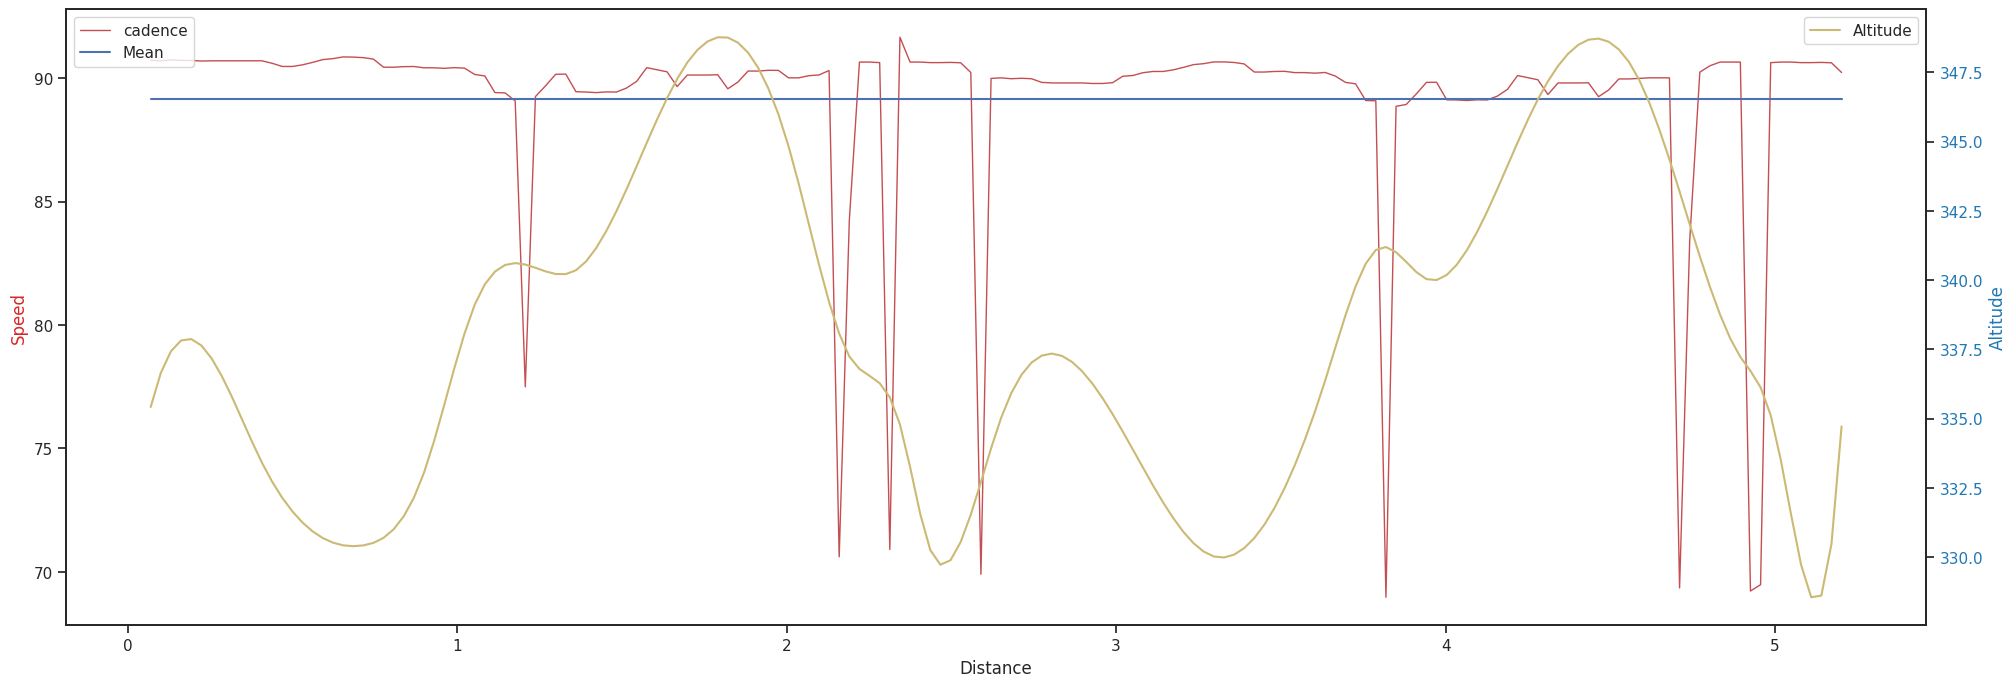

In [91]:
_, _ = evl.plot(df=test_df[percent_delay:],pred=test_df['cadence'][percent_delay:],endog = "cadence")

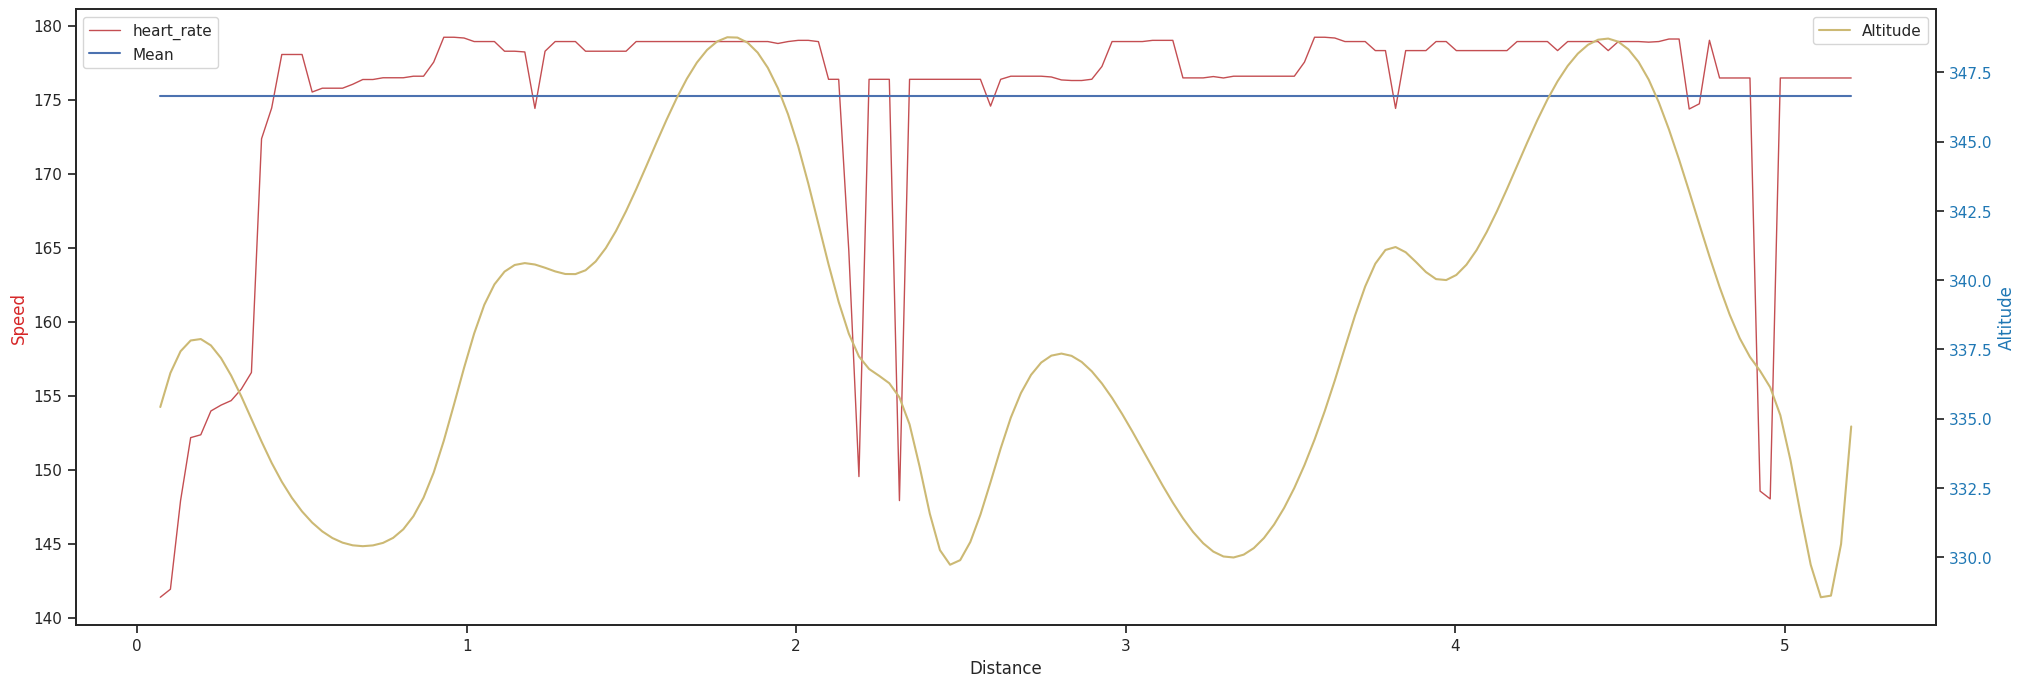

In [92]:
_, _ = evl.plot(df=test_df[percent_delay:],pred=test_df['heart_rate'][percent_delay:],endog = "heart_rate")

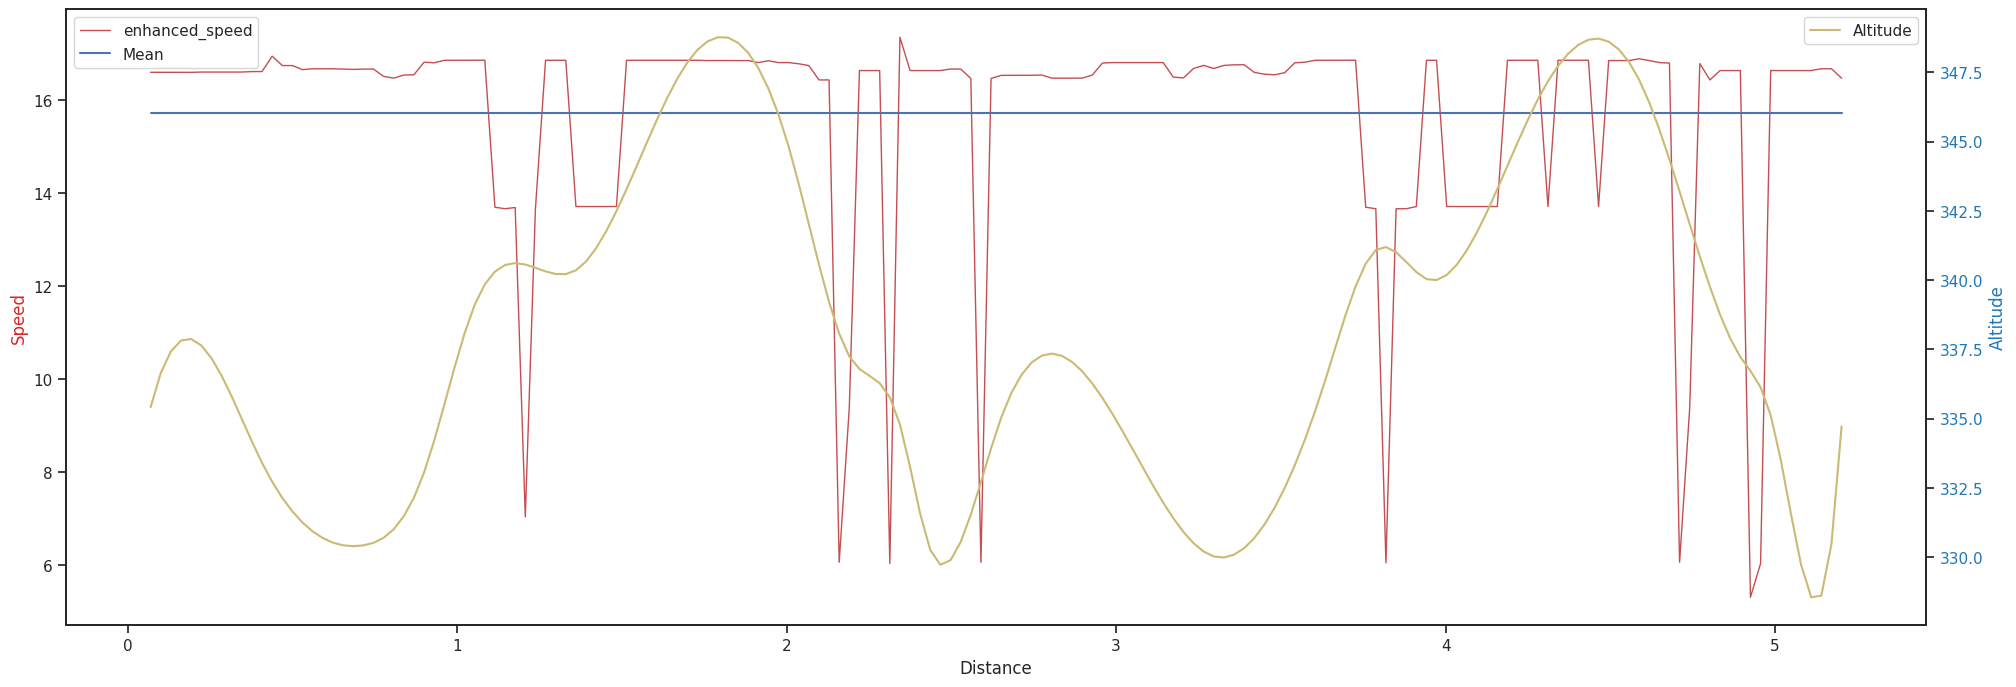

In [93]:
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_ridge[percent_delay:],endog = "enhanced_speed")

In [94]:
np.mean(test_df.cadence), np.mean(test_df.heart_rate)

(89.08547, 174.21162)

In [95]:
y_pred_ridge = [x if x > 15 else np.mean(y_pred_ridge) or x if x < 30 else np.mean(y_pred_ridge) for x in y_pred_ridge]

In [96]:
import math
# np.mean(speed_test), np.mean(y_pred_ridge), max(test_df.distance)
time = ((np.max(test_df.distance) / 1000) / np.mean(y_pred_ridge)) * 60
minutes = math.floor(time)
seconds = round((time - minutes) * 60)
f'Final time: {minutes}:{seconds}'

'Final time: 18:55'

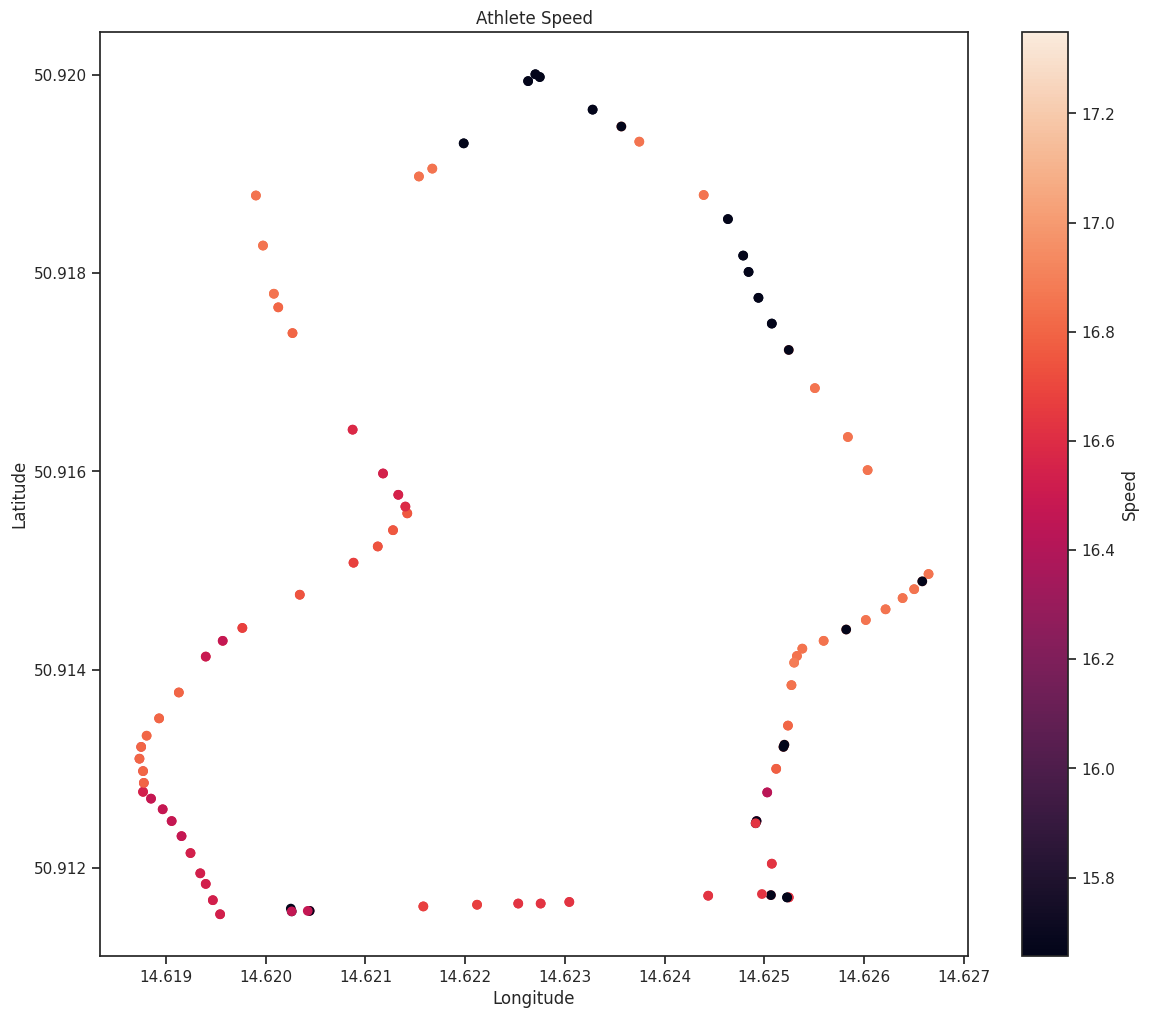

In [97]:
df_map = Converter(input_file='silvestrak_mapy.gpx').gpx_to_dataframe()
lons = df_map.longitude
lats = df_map.latitude
speed = y_pred_ridge

plt.figure(figsize = (14, 12))
plt.title('Athlete Speed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(lons, lats, c = speed)
cbar = plt.colorbar()
cbar.set_label('Speed')

In [98]:
import folium
from branca.element import Figure
from folium import plugins
fig5=Figure(height=550,width=750)
map=folium.Map(location=[df_map.latitude[0], df_map.longitude[0]],tiles='cartodbpositron',zoom_start=14)
fig5.add_child(map)

coords = [[x,y] for x,y in zip(df_map.latitude, df_map.longitude)]
f1=folium.FeatureGroup("Athlete")
line_1=folium.vector_layers.PolyLine(coords,popup='<b>Path of the athlete/b>',tooltip='Athlete',color='blue',weight=10).add_to(f1)
f1.add_to(map)
folium.LayerControl().add_to(map)

In [99]:
max = 255/np.max(y_pred_ridge)
speed = [int(max * x) for x in y_pred_ridge]

def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

In [100]:
cbar.set_label('Speed')
import folium
from branca.element import Figure
my_map=folium.Map(location=[df_map.latitude[0], df_map.longitude[0]],tiles='cartodbpositron',zoom_start=14)


# for lat,long in zip(df_map.latitude, df_map.longitude):
#     folium.Marker([lat, long], tooltip="Kbely").add_to(my_map)

for x, sped in zip(range(len(coords)),speed):
    folium.PolyLine(
        coords[x:x+2],
        color=f"#{rgb_to_hex((sped,50,100))}",
        weight=10
    ).add_to(my_map)

my_map

In [101]:
hex(int(y_pred_ridge[32]))

'0x10'